In [1]:
#%load_ext autotime
import hanford.paths
import yaml
import os
import copy
import numpy as np
import numpy.random as npr
import scipy.optimize as spo
import scipy.linalg as spl
from matplotlib import pyplot as plt, path as mpath, collections as mc, patches as mpatches, cm, ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sdfs.geom_mrst import GeomMRST
from sdfs.bc_mrst import BCMRST
from sdfs.darcy_old import DarcyExp
from sdfs.tpfa import TPFA
from sdfs.dasa_old import DASAExpLM, DASAExpLMWithFlux
from time import perf_counter
import ckli.mapest_old as mapest
#import ckli.ckliest_testing as ckliest
import ckli.ckliest_h1reg as ckliest
import h5py
import GPy

In [2]:
plt.rc('text', usetex=True)
plt.rc('image', cmap='plasma')

def plot_patch(patches, values, fig, ax, points, title, cmin=None, cmax=None, cb=False):
    p = mc.PatchCollection(patches, cmap=cm.jet)
    p.set_array(values)
    p.set_clim([cmin, cmax])
    ax.add_collection(p)
    if points is not None:
        ax.plot(*points, 'ko', markersize=0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.autoscale(tight=True)
    #ax.set_title(title)
    if cb:
        fig.colorbar(p, ax=ax)
    return p

In [3]:
# Parameters
res_fac = 1
resolution = '1x'
geom_filename = f'hanford_data/geom_{resolution}.mat'
bc_filename = f'hanford_data/bc_{resolution}.mat'
conduct_filename = f'hanford_data/conduct_log_{resolution}.mat'
well_cells_filename = f'hanford_data/well_cells_{resolution}.mat'
ev_gpr_filename = 'hanford_data/eigenvalues_gpr.npy'
num_trials = 10
seed = 0
#Nuobs = 50
NYobs = 50
NYlearn = NYobs
NYrefobs = 50
NYxi = 1000
Nuxi = 1000
Nens = 5000
beta_ckli = 1e1
Ygamma_ckli = 1e-4
ugamma_ckli = Ygamma_ckli
gamma_map = 1e-6
std_dev_ref = 1.0
cor_len_ref = 0.1
Neumann_sd = 1
run_PICKLE = True
run_MAP = True
lsq_method = 'trf'
yobs_filename = f'hanford_data/yobs_{NYobs}_{resolution}.npy'
ref = f"Yref=gpml_{NYrefobs}_{resolution}"

In [4]:
Yfac = 7.0 # Rescaling factor for log-conductivity. Must be applied to Yref and the BCs

geom = GeomMRST(geom_filename)
bc = BCMRST(geom, bc_filename)
bc.rescale('N', Yfac)
prob = DarcyExp(TPFA(geom, bc), None)

Nc = geom.cells.num
Ninf = geom.faces.num_interior
print(f'Ninf = {Ninf}, Nc = {Nc}')

Ninf = 2766, Nc = 1475


In [5]:
patches = [mpatches.Polygon(v, closed=True) for v in geom.nodes.coords.T[geom.cells.nodes.T, :]]

In [6]:
# Observations
rs = npr.RandomState(seed)

# Read stochastic model from GPML output
with h5py.File(f'hanford/gpml/hanford_david_{NYrefobs}_{resolution}.mat', 'r') as f:
    Yref = f.get('mu')[:].ravel() - Yfac
    CYpred = f.get('Kp')[:]
    xrefYobs = f.get('xYobs')[:]

uref = prob.randomize_bc('N', Neumann_sd).solve(Yref)

# u observations
with h5py.File(well_cells_filename, 'r') as f:
    iuobs = f.get('well_cells')[:].ravel() - 1
uobs = uref[iuobs]
Nuobs = iuobs.size

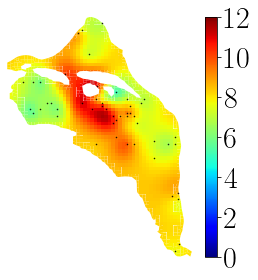

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
p = plot_patch(patches, Yref + Yfac, fig, ax, xrefYobs, 'Yref', 0, 12)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize='30')
cbar.locator = ticker.MaxNLocator(nbins=7)
cbar.update_ticks()
fig.tight_layout()
fig.savefig(f'hanford/figures/Yref/Yref_{ref}.pdf', dpi=300)

In [8]:
rl2e = lambda yest, yref : spl.norm(yest - yref, 2) / spl.norm(yref, 2)
infe = lambda yest, yref : spl.norm(yest - yref, np.inf)

In [9]:
if os.path.exists(yobs_filename):
    print(f"iYobs set read from file {yobs_filename}")
    iYobs = np.load(yobs_filename)
else:
    print(f"iYobs set randomly generated and saved to {yobs_filename}")
    iYobs = np.array([np.sort(rs.choice(Nc, NYobs, replace=False)) for _ in range(num_trials)])
    np.save(yobs_filename, iYobs)
print(f"{iYobs.shape=}")
print(iYobs)

iYobs set read from file hanford_data/yobs_50_1x.npy
iYobs.shape=(10, 50)
[[  31   54   82  148  152  191  192  231  254  260  278  302  322  326
   361  362  376  408  420  434  446  458  483  487  529  558  651  674
   758  761  838  853  857  884  897  900 1030 1031 1061 1114 1157 1187
  1280 1285 1338 1347 1352 1402 1444 1465]
 [  22   56  117  118  138  146  181  183  213  216  248  302  306  311
   352  436  454  495  533  537  545  547  548  600  611  615  643  673
   681  692  695  719  760  786  787  802  806  841  933  968 1005 1009
  1038 1083 1086 1225 1242 1294 1323 1364]
 [   0   42   55   90   96  116  127  130  152  158  159  218  269  282
   328  339  392  401  402  484  530  541  567  571  612  650  658  715
   756  783  804  809  930  941  962  981 1003 1035 1045 1057 1084 1099
  1106 1158 1165 1194 1304 1340 1361 1444]
 [ 107  112  127  144  151  164  170  261  263  279  290  332  337  343
   405  425  485  547  557  569  581  592  620  629  660  676  684  693
   69

In [10]:
exp = f'NY={NYobs}_Nu={iuobs.size}_{NYlearn=}_{Nuxi=}_{NYxi=}_beta={beta_ckli}_gamma={ugamma_ckli}_Neumann_sd={Neumann_sd}_{lsq_method=}_h1reg_{ref}'
print(exp)

NY=50_Nu=323_NYlearn=50_Nuxi=1000_NYxi=1000_beta=10.0_gamma=0.0001_Neumann_sd=1_lsq_method='trf'_h1reg_Yref=gpml_50_1x


In [11]:
timings = np.zeros((num_trials, 6))
nfevs = np.zeros((num_trials, 3), dtype=int)
rel_errors = np.zeros((num_trials, 4))
abs_errors = np.zeros((num_trials, 4))

Yobs = np.zeros((num_trials, NYobs))
Ypred = np.zeros((num_trials, Nc))
CYpred = np.zeros((num_trials, Nc, Nc))
umean = np.zeros((num_trials, Nc))
Cu = np.zeros((num_trials, Nc, Nc))
upred = np.zeros((num_trials, Nc))
Cupred = np.zeros((num_trials, Nc, Nc))

PsiY = np.zeros((num_trials, Nc, NYxi))
LambdaY = np.zeros((num_trials, NYxi))
Psiu = np.zeros((num_trials, Nc, Nuxi))
Lambdau = np.zeros((num_trials, Nuxi))

Yxi = np.zeros((num_trials, NYxi))
uxi = np.zeros((num_trials, Nuxi))
Yest = np.zeros((num_trials, Nc))
uest = np.zeros((num_trials, Nc))
Yest_MAPH1 = np.zeros((num_trials, Nc))
if Neumann_sd != 0:
    Nq = np.count_nonzero(bc.kind == 'N')
    q_MAPH1 = np.zeros((num_trials, Nq))

In [12]:
for t in range(num_trials):
    iYlearn = iYobs[t]
    Ylearn = Yref[iYlearn]
    Yobs[t] = Yref[iYobs[t]]

    ts = perf_counter()
    klearn = GPy.kern.sde_Matern52(input_dim=2, variance=std_dev_ref**2, lengthscale=cor_len_ref)
    mYlearn = GPy.models.GPRegression(geom.cells.centroids[:, iYlearn].T, Ylearn[:,None], klearn, noise_var=np.sqrt(np.finfo(float).eps))
    mYlearn.optimize(messages=True, ipython_notebook=False)
    print(f"{klearn.lengthscale.values[0]=}")
    print(f"{np.sqrt(klearn.variance.values[0])=}")

    mYref = GPy.models.GPRegression(geom.cells.centroids[:, iYobs[t]].T, Yobs[t,:, None], mYlearn.kern, noise_var=np.sqrt(np.finfo(float).eps))
    Ypred[t], CYpred[t] = (lambda x, y : (x.ravel(), y))(*mYref.predict_noiseless(geom.cells.centroids.T, full_cov=True))
    timings[t, 0] = perf_counter() - ts

print(f"GPR: {timings[:, 0]} s")

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0002   6.877273e+01   1.700395e+03 
    00s04  0009   4.283453e+01   6.299902e-01 
    00s07  0012   4.280805e+01   5.233639e-05 
    00s08  0015   4.280805e+01   2.242358e-10 
Runtime:     00s08
Optimization status: Converged

klearn.lengthscale.values[0]=0.09470708643286228
np.sqrt(klearn.variance.values[0])=1.3902891151412304
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0004   4.047275e+01   5.455484e+01 
    00s06  0009   3.827954e+01   1.202517e-01 
    00s07  0011   3.826045e+01   2.911753e-03 
    00s10  0015   3.826043e+01   8.111689e-10 
Runtime:     00s10
Optimization status: Converged

klearn.lengthscale.values[0]=0.09162655028654079
np.sqrt(klearn.variance.values[0])=1.3616712552418133
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0003   3.776369e+01   5.11281

In [13]:
for t in range(num_trials):
    # Compute GP model for u
    ts = perf_counter()
    umean[t], Cu[t] = ckliest.smc_gp(Ypred[t], CYpred[t], Nens, copy.deepcopy(prob), rs, randomize_bc=True, randomize_scale=Neumann_sd)
    upred[t], Cupred[t] = ckliest.gpr(umean[t], Cu[t], uobs, iuobs)
    timings[t, 1] = perf_counter() - ts

print(f"Monte Carlo: {timings[:, 1]} s")

Monte Carlo: [33.54328159 33.22920584 33.21880545 32.68182616 32.47917794 32.76605519
 32.98698158 33.83978919 33.64025592 33.97933708] s


In [14]:
# PICKLE models
Ym = Ypred
CYm = CYpred
um = umean #or change to upred
Cum = Cu #or change to Cupred

rel_errors[:, 0] = np.array([rl2e(Ym[t], Yref) for t in range(num_trials)])
abs_errors[:, 0] = np.array([infe(Ym[t], Yref) for t in range(num_trials)])

print(f"GPR\tRelative error: {rel_errors[:, 0]}")
print(f"GPR\tInfinity error: {abs_errors[:, 0]}")

GPR	Relative error: [0.38543669 0.29062538 0.29786205 0.27354311 0.34670491 0.39823831
 0.25895738 0.31241917 0.29189476 0.20656199]
GPR	Infinity error: [4.36045604 2.19701018 2.22466146 3.04497565 2.26227514 3.39363767
 2.39672425 2.79413074 2.61191279 2.10501601]


In [15]:
for t in range(num_trials):
    ts = perf_counter()
    PsiY[t], LambdaY[t] = ckliest.KL_via_eigh(CYm[t], NYxi)
    Psiu[t], Lambdau[t] = ckliest.KL_via_eigh(Cum[t], Nuxi)
    timings[t, 2] = perf_counter() - ts

print(f"eigendecomposition: {timings[:, 2]} s")

eigendecomposition: [5.96635503 5.75837946 5.85013145 5.94833662 5.74426238 5.6128272
 5.85041305 5.54600665 5.5211958  5.60872083] s


In [16]:
Lreg = mapest.compute_Lreg(geom)
if run_PICKLE:
    for t in range(num_trials):
        # PICKLE estimate
        #ssf = 4
        #ssv = rs.choice(Nc, np.int_(np.ceil(Nc / ssf)), replace=False)
        ssv = None if Neumann_sd == 0 else np.delete(np.arange(Nc), np.unique(geom.cells.to_hf[2*geom.faces.num_interior:][bc.kind == 'N']))
        
        res = ckliest.LeastSqRes(NYxi, Ym[t], PsiY[t], Nuxi, um[t], Psiu[t], prob, ugamma_ckli, Ygamma_ckli, res_fac, Lreg, iuobs, uobs, iYobs[t], Yobs[t], beta_ckli, ssv=ssv)
        x0 = np.zeros(Nuxi + NYxi)
            
        ts = perf_counter()
        sol = spo.least_squares(res.val, x0, jac=res.jac, method=lsq_method, verbose=2)
        ckli_status = sol.status
        timings[t, 3] = perf_counter() - ts
        nfevs[t, 0] = sol.nfev
        print(f'CKLI optimality: {sol.optimality : g}')

        uxi[t] = sol.x[:Nuxi]
        Yxi[t] = sol.x[Nuxi:]
        uest[t] = um[t] + Psiu[t] @ uxi[t]
        Yest[t] = Ym[t] + PsiY[t] @ Yxi[t]

rel_errors[:, 1] = np.array([rl2e(Yest[t], Yref) for t in range(num_trials)])
abs_errors[:, 1] = np.array([infe(Yest[t], Yref) for t in range(num_trials)])

print(f"PICKLE: {timings[:, 3]} s")
print(f"PICKLE\trelative L2 error: {rel_errors[:, 1]}")
print(f"PICKLE\tabsolute Infinity error: {abs_errors[:, 1]}")

01       4.00e+00       5.79e-01    
       4              5         7.6448e-01      5.72e+00       8.00e+00       2.06e-01    
       5              6         2.6099e-01      5.03e-01       1.60e+01       3.85e-01    
       6              7         3.9634e-02      2.21e-01       1.60e+01       1.28e-01    
       7              9         3.4417e-02      5.22e-03       8.00e+00       1.35e-02    
       8             10         3.3897e-02      5.20e-04       1.60e+01       7.10e-02    
       9             11         3.3153e-02      7.44e-04       1.60e+01       5.98e-03    
      10             12         3.3132e-02      2.09e-05       3.20e+01       4.20e-02    
      11             13         3.2787e-02      3.45e-04       8.00e+00       2.36e-03    
      12             14         3.2759e-02      2.82e-05       1.60e+01       2.28e-03    
      13             15         3.2745e-02      1.44e-05       1.76e+01       7.15e-04    
      14             16         3.2742e-02      2.93e

In [17]:
if run_MAP:
    # MAP H1 estimate
    for t in range(num_trials):
        if Neumann_sd == 0:
            loss = mapest.LossVec(Nc, Nc, iuobs, uobs, iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
            dasa = DASAExpLM(loss.val, loss.grad_u, loss.grad_Y, prob.solve, prob.residual_sens_u, prob.residual_sens_Y)
            ts = perf_counter()
            sol = spo.least_squares(dasa.obj, np.zeros(Nc), jac=dasa.grad, method=lsq_method, verbose=2)
            Yest_MAPH1[t] = sol.x
        else:
            loss = mapest.LossVecWithFlux(Nc, Nc, Nq, iuobs, uobs, iYobs[t], Yobs[t], gamma_map, Lreg) # H1 regularization
            dasa = DASAExpLMWithFlux(Nc, loss.val, loss.grad_u, loss.grad_p, prob.solve, prob.residual_sens_u, prob.residual_sens_p)
            ts = perf_counter()
            sol = spo.least_squares(dasa.obj, np.zeros(Nc + Nq), jac=dasa.grad, method=lsq_method, verbose=2)
            Yest_MAPH1[t] = sol.x[:Nc]
            q_MAPH1[t] = sol.x[Nc:]
        MAP_status = sol.status
        timings[t, 4] = perf_counter() - ts
        nfevs[t, 1] = sol.nfev
        print(f'MAP status: {MAP_status}, message: {sol.message}')

rel_errors[:, 2] = np.array([rl2e(Yest_MAPH1[t], Yref) for t in range(num_trials)])
abs_errors[:, 2] = np.array([infe(Yest_MAPH1[t], Yref) for t in range(num_trials)])

print(f"MAP: {timings[:, 4]} s")
print(f"MAP\trelative L2 error: {rel_errors[:, 2]}")
print(f"MAP\tabsolute infinity error: {abs_errors[:, 2]}")

     9.10e-03    
      26             34         7.9415e-05      6.78e-07       8.28e-01       9.79e-03    
      27             35         7.6795e-05      2.62e-06       2.07e-01       6.28e-04    
      28             36         7.6480e-05      3.14e-07       4.14e-01       2.49e-03    
      29             37         7.6060e-05      4.20e-07       4.14e-01       2.57e-03    
      30             38         7.5664e-05      3.97e-07       4.14e-01       2.63e-03    
      31             39         7.5292e-05      3.72e-07       4.14e-01       2.67e-03    
      32             40         7.4944e-05      3.48e-07       4.14e-01       2.70e-03    
      33             41         7.4619e-05      3.25e-07       4.14e-01       2.71e-03    
      34             42         7.4316e-05      3.03e-07       4.14e-01       2.71e-03    
      35             43         7.4035e-05      2.81e-07       4.14e-01       2.69e-03    
      36             44         7.3776e-05      2.59e-07       4.14e-01 

In [18]:
np.savetxt(f'hanford/results/iYobs/iYobs_{exp}.txt', iYobs.astype(int), fmt='%i')
np.savetxt(f'hanford/results/timings/timings_{exp}.txt', timings)
np.savetxt(f'hanford/results/nfevs/nfevs_{exp}.txt', nfevs.astype(int), fmt='%i')
np.savetxt(f'hanford/results/rel_errors/rel_errors_{exp}.txt', rel_errors)
np.savetxt(f'hanford/results/abs_errors/abs_errors_{exp}.txt', abs_errors)
np.savetxt(f'hanford/results/YGPR/YGPR_{exp}.txt', Yref)
np.savetxt(f'hanford/results/YPICKLE/YPICKLE_{exp}.txt', Yest)
np.savetxt(f'hanford/results/YMAP/YMAP_{exp}.txt', Yest_MAPH1)